# Load packages and help functions

In [1]:
# Add local repository to python path -> allows for importing here
#import sys
#sys.path.append('/COMBINE')

# plotting package
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)  # Default plot size
import seaborn as sns
sns.set(font_scale=2)

# Scientific packages
import numpy as np
import salem
import glob
import os
import oggm

# Constants
from oggm import cfg
cfg.initialize()

# OGGM models
from oggm.core.massbalance import LinearMassBalance
from oggm.core.flowline import FluxBasedModel as oggm_FluxModel
from oggm.core.flowline import RectangularBedFlowline as oggm_flowline
from oggm.core.flowline import ParabolicBedFlowline as oggm_para_flowline
from oggm.core.flowline import TrapezoidalBedFlowline as oggm_trap_flowline

# MUSCLsuperbee model
from MUSCL.MUSCL_flowline import MUSCLSuperBeeModel

# COMBINE models
from combine.core.flowline_adapted import RectangularBedDiffusiveFlowlineModel as combine_DiffusiveFlowlineModel
from combine.core.flowline_adapted import FluxBasedModel as combine_FluxFlowlineModel
from combine.core.flowline_adapted import RectangularBedFlowline as combine_flowline
from combine.core.flowline_adapted import ParabolicBedFlowline as combine_para_flowline
from combine.core.flowline_adapted import TrapezoidalBedFlowline as combine_trap_flowline

import torch

2020-12-14 09:51:21: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-12-14 09:51:21: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-12-14 09:51:21: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-12-14 09:51:21: oggm.utils: Checking the download verification file checksum...


In [2]:
import timeit
from functools import partial


# function to time function execution time
def time_fct(model_run_fct, year):
    timeit_fct = partial(timeit.timeit, number=1)
    return timeit_fct(partial(model_run_fct, year))


# function to compare volume
def compare_vol(models): 
    header_format ="{:>15}" * (len(models) + 1)

    names = []
    for model in models:
        names.append(model.name)
    print(header_format.format("", *names))

    data = [ [ 0 for y in range(len(models)) ] 
             for x in range(len(models)) ] 
    for row, model_row in enumerate(models):
        for col, model_col in enumerate(models):
            data[col][row] = model_row.fls[-1].volume_km3 - model_col.fls[-1].volume_km3

    row_format = "{:>15}" + ("{:15.2E}" * len(models))
    for name, row in zip(names, data):
        print(row_format.format(name, *row))

# Test dynamic Model in idealized setting

## Define simple linear glacier bed with constant width

In [3]:
# number of steps from bottem to top of glacier
nx = 200

# model grid spacing in m
map_dx = 100

# distance along glacier (x-axis of glacier profil plot) in km
distance_along_glacier = np.linspace(0, nx, nx) * map_dx * 1e-3

# glacier top height
glacier_top_height = 4000

# glacier bottom height
glacier_bottom_height = 0

# define linear glacier bed with zero ice thickness
bed_h = np.linspace(glacier_top_height, 0, nx)
surface_h = bed_h

# define width, so glacier bed could be created when plot is created (after creation model is ready)
widths = np.zeros(nx) + 4.
#widths = np.array([(-2 / nx * x + 2.5) * 2 for x in np.arange(nx)])

## define flowlines

In [4]:
oggm_fl = oggm_flowline(surface_h=surface_h, bed_h=bed_h,
                        widths=widths/map_dx, map_dx=map_dx)

combine_fl = combine_flowline(surface_h=surface_h, bed_h=bed_h,
                              widths=widths/map_dx, map_dx=map_dx, torch_type=torch.double)

## Define linear constant mass balance model

In [5]:
ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

## Define actual models

In [6]:
# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

muscl_model = MUSCLSuperBeeModel(oggm_fl, mb_model=mb_model, y0=0.)

# combine_diff_model = combine_DiffusiveFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
combine_flux_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
#combine_flux_model_adapted = combine_FluxFlowlineModel_adapted(combine_fl, mb_model=mb_model, y0=0.)

functions to time Model runs

In [7]:
import timeit
from functools import partial

# function to time function execution time
def time_fct(model_run_fct, year):
    timeit_fct = partial(timeit.timeit, number=1)
    return timeit_fct(partial(model_run_fct, year))

In [8]:
def oggm_run(year):
    oggm_model.run_until(year)

def muscl_run(year):
    muscl_model.run_until(year)

def combine_diff_run(year):
    combine_diff_model.run_until(year)

def combine_flux_run(year):
    combine_flux_model.run_until(year)

def combine_flux_adapted_run(year):
    combine_flux_model_adapted.run_until(year)

## Run all models for 200 years

In [9]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'MUSCL: {:.2f} s\n'.format(time_fct(muscl_run, years))+
      #'COMBINE Diff:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_diff_run, years), 
      #                                                   combine_diff_model.iterations) +
      'COMBINE Flux:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_flux_run, years), 
                                                         combine_flux_model.iterations))
      #'COMBINE Flux adapted:  {:.2f} s, Iterations: {:d}'.format(time_fct(combine_flux_adapted_run, years), 
      #                                                   combine_flux_model_adapted.iterations))

OGGM: 1.16 s
MUSCL: 2.26 s
COMBINE Flux:  3.88 s, Iterations: 9120



## Compare outcome

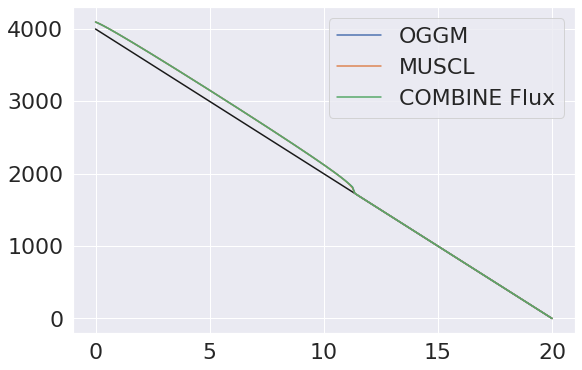

In [10]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, muscl_model.fls[-1].surface_h, label='MUSCL')
# plt.plot(distance_along_glacier, combine_diff_model.fls[-1].surface_h, label='COMBINE Diff')
plt.plot(distance_along_glacier, combine_flux_model.fls[-1].surface_h, label='COMBINE Flux')
#plt.plot(distance_along_glacier, combine_flux_model_adapted.fls[-1].surface_h, label='COMBINE Flux adapted')
plt.legend()

In [11]:
# function to compare volume
def compare_vol(models): 
    header_format ="{:>15}" * (len(models) + 1)

    names = []
    for model in models:
        names.append(model.name)
    print(header_format.format("", *names))

    data = [ [ 0 for y in range(len(models)) ] 
             for x in range(len(models)) ] 
    for row, model_row in enumerate(models):
        for col, model_col in enumerate(models):
            data[col][row] = model_row.fls[-1].volume_km3 - model_col.fls[-1].volume_km3

    row_format = "{:>15}" + ("{:15.2E}" * len(models))
    for name, row in zip(names, data):
        print(row_format.format(name, *row))

In [12]:
oggm_model.name = 'OGGM'
muscl_model.name = 'MUSCL'
# combine_diff_model.name = 'COMBINE Diff'
combine_flux_model.name = 'COMBINE Flux'
#combine_flux_model_adapted.name = 'COMBINE Flux v2'
compare_vol([oggm_model, muscl_model, combine_flux_model])

                          OGGM          MUSCL   COMBINE Flux
           OGGM       0.00E+00      -9.24E-06      -2.60E-18
          MUSCL       9.24E-06       0.00E+00       9.24E-06
   COMBINE Flux       2.60E-18      -9.24E-06       0.00E+00


# Test dynamic Model on more realistic topography

## Try with Hintereisferner

### If running the first time 

In [3]:
from oggm import workflow, utils

In [42]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test_border_160'#utils.gettempdir(dirname='Hintereisferner_test', reset=True)
cfg.PATHS['working_dir']

'Hintereisferner_test_border_160'

In [43]:
rgi_ids = ['RGI60-11.00897']

In [44]:
gdirs = workflow.init_glacier_regions(rgi_ids, from_prepro_level=2, prepro_border=160)

2020-12-14 10:00:47: oggm.workflow: init_glacier_regions from prepro level 2 on 1 glaciers.
2020-12-14 10:00:47: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2020-12-14 10:00:49: oggm.core.gis: (RGI60-11.00897) glacier_masks
2020-12-14 10:00:49: oggm.core.gis: (RGI60-11.00897) process_dem


In [45]:
from oggm import tasks

In [46]:
workflow.execute_entity_task(tasks.glacier_masks, gdirs);

2020-12-14 10:00:49: oggm.workflow: Execute entity task glacier_masks on 1 glaciers


In [47]:
# only calculate one flowline
cfg.PARAMS['use_multiple_flowlines'] = False

list_talks = [
         tasks.compute_centerlines,
         tasks.initialize_flowlines,
         tasks.compute_downstream_line,
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2020-12-14 10:00:51: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2020-12-14 10:00:51: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2020-12-14 10:00:52: oggm.workflow: Execute entity task initialize_flowlines on 1 glaciers
2020-12-14 10:00:52: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2020-12-14 10:00:52: oggm.workflow: Execute entity task compute_downstream_line on 1 glaciers
2020-12-14 10:00:52: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2020-12-14 10:00:57: oggm.core.centerlines: (RGI60-11.00897) catchment_area
2020-12-14 10:00:57: oggm.core.centerlines: (RGI60-11.00897) catchment_width_geom
2020-12-14 10:00:58: oggm.core.centerlines: (RGI60-11.00897) catchment_width_correction
2020-12-14 10:00:58: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape
2020-12-14 10:00:59: oggm.core.climate: (RGI60-11.00897) local_t_star
2020-12-14 10:00:59: oggm.core.climate: (RGI60-11.00897) local mu* compu

In [48]:
from oggm import graphics

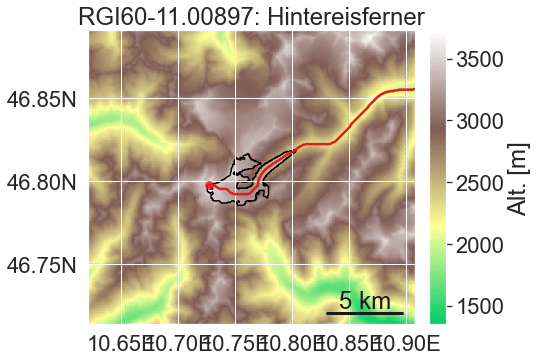

In [49]:
graphics.plot_centerlines(gdirs[0], figsize=(8, 7), use_flowlines=True, add_downstream=True)

In [50]:
list_talks = [
         tasks.catchment_area,
         tasks.catchment_width_geom,
         tasks.catchment_width_correction,
         tasks.compute_downstream_bedshape
         ]
for task in list_talks:
    # The order matters!
    workflow.execute_entity_task(task, gdirs)

2020-12-14 10:00:57: oggm.workflow: Execute entity task catchment_area on 1 glaciers
2020-12-14 10:00:57: oggm.workflow: Execute entity task catchment_width_geom on 1 glaciers
2020-12-14 10:00:58: oggm.workflow: Execute entity task catchment_width_correction on 1 glaciers
2020-12-14 10:00:58: oggm.workflow: Execute entity task compute_downstream_bedshape on 1 glaciers


In [51]:
workflow.execute_entity_task(tasks.local_t_star, gdirs);
workflow.execute_entity_task(tasks.mu_star_calibration, gdirs);

2020-12-14 10:00:59: oggm.workflow: Execute entity task local_t_star on 1 glaciers
2020-12-14 10:00:59: oggm.workflow: Execute entity task mu_star_calibration on 1 glaciers


In [52]:
list_talks = [
         tasks.prepare_for_inversion,  # This is a preprocessing task
         tasks.mass_conservation_inversion,  # This does the actual job
         tasks.filter_inversion_output  # This smoothes the thicknesses at the tongue a little
         ]
for task in list_talks:
    workflow.execute_entity_task(task, gdirs)

2020-12-14 10:00:59: oggm.workflow: Execute entity task prepare_for_inversion on 1 glaciers
2020-12-14 10:00:59: oggm.workflow: Execute entity task mass_conservation_inversion on 1 glaciers
2020-12-14 10:00:59: oggm.workflow: Execute entity task filter_inversion_output on 1 glaciers


In [53]:
# Convert the flowlines to a "glacier" for the ice dynamics module
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs);

2020-12-14 10:01:02: oggm.workflow: Execute entity task init_present_time_glacier on 1 glaciers


In [54]:
gdir = gdirs[0]

### If already downloaded and preprocessed

In [59]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test_border_160'
gdir = oggm.GlacierDirectory('RGI60-11.00897')

### Start of Experiments

In [60]:
fls = gdir.read_pickle('model_flowlines')

In [61]:
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3

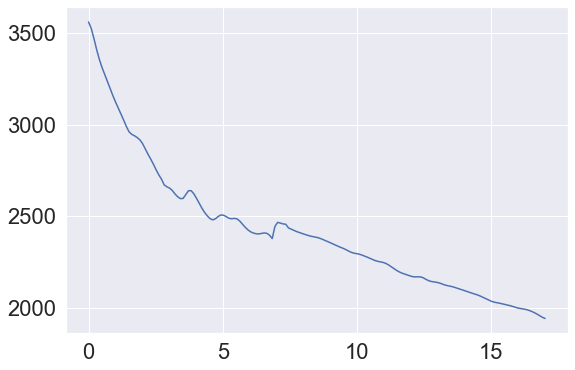

In [62]:
plt.plot(distance_along_glacier, fls[0].surface_h - fls[0].thick)

In [66]:
fls[0].bed_shape

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan, 0.00107054, 0.00120932,
       0.00133276, 0.00163194, 0.00215384, 0.00252789, 0.00269482,
       0.00250768, 0.00165607, 0.00113463, 0.0011865 , 0.00144704,
       0.00162967, 0.00186586, 0.00224803, 0.00248859, 0.00253416,
       0.00262055, 0.00263808, 0.00248462, 0.00223089, 0.0019766 ,
       0.0018938 , 0.00192726, 0.00198884, 0.00205006, 0.00202163,
       0.00201426, 0.00223581, 0.00275373, 0.00325139, 0.00356528,
       0.0037691 , 0.00390319, 0.00403195, 0.00410994, 0.00406024,
       0.00412114, 0.00453837, 0.00528921, 0.00667731, 0.00339772,
       0.00168472, 0.00172862, 0.00179631, 0.00128631, 0.00165

In [75]:
calc_shape = np.where(fls[0].widths_m >= 10,
         4 * fls[0].thick /
         fls[0].widths_m**2,
         4 * fls[0].thick / 10**2)

<ipython-input-75-f6316ede03dd>:2: RuntimeWarning: invalid value encountered in true_divide
  4 * fls[0].thick /


In [77]:
bed_shape = np.where(np.isnan(fls[0].bed_shape),
                     calc_shape,
                     fls[0].bed_shape)

In [79]:
fls[0].thick

array([ 52.28565386,  51.64199333,  49.17308777,  50.89340972,
        55.02640676,  59.73032809,  62.17813362,  64.67993787,
        69.75922136,  76.51720337,  83.05611539,  88.68535816,
        94.41590237, 104.76307962, 121.42574777, 136.55934608,
       137.4380987 , 130.43205928, 123.84223727, 119.33083672,
       121.37179787, 131.56548911, 143.62712393, 154.2793513 ,
       168.76307687, 187.59915564, 205.64539061, 220.35226547,
       243.3411357 , 245.88878811, 244.44608889, 248.77178017,
       259.46654834, 267.15147211, 269.43651409, 260.91816948,
       231.15758085, 199.66668347, 187.00363182, 191.16146611,
       204.01129448, 220.16257684, 237.59536102, 252.84242537,
       263.55942059, 271.27423088, 270.99400612, 257.78213142,
       237.52164051, 220.50713533, 212.2276776 , 210.45608008,
       209.55511442, 202.41405276, 189.78274385, 181.24898699,
       181.20252086, 186.8210683 , 192.53465392, 196.36230423,
       197.11422116, 193.78821648, 187.86588069, 178.65

In [78]:
bed_shape

array([6.37829493e-04, 7.50510610e-04, 8.36696571e-04, 4.06879920e-04,
       1.36005982e-04, 5.46107783e-05, 2.77536691e-05, 2.25087920e-05,
       2.67129865e-05, 3.33813849e-05, 4.28223335e-05, 5.99267270e-05,
       6.84644005e-05, 6.54074832e-05, 6.72899000e-05, 7.75975512e-05,
       8.87382627e-05, 9.23874839e-05, 8.33476036e-05, 7.80432846e-05,
       1.11110914e-04, 2.22784457e-04, 3.64812268e-04, 4.15736299e-04,
       4.47738191e-04, 5.18174132e-04, 6.46204682e-04, 8.34175965e-04,
       1.07053754e-03, 1.20931507e-03, 1.33275953e-03, 1.63193999e-03,
       2.15384282e-03, 2.52789218e-03, 2.69481631e-03, 2.50768085e-03,
       1.65606953e-03, 1.13463277e-03, 1.18650476e-03, 1.44703823e-03,
       1.62966836e-03, 1.86585839e-03, 2.24802754e-03, 2.48858553e-03,
       2.53416404e-03, 2.62054503e-03, 2.63808305e-03, 2.48462308e-03,
       2.23089336e-03, 1.97660202e-03, 1.89380224e-03, 1.92725502e-03,
       1.98884253e-03, 2.05005858e-03, 2.02163332e-03, 2.01426220e-03,
      

In [81]:
shape

array([0.00107054, 0.00107054, 0.00107054, 0.00107054, 0.00107054,
       0.00107054, 0.00107054, 0.00107054, 0.00107054, 0.00107054,
       0.00107054, 0.00107054, 0.00107054, 0.00107054, 0.00107054,
       0.00107054, 0.00107054, 0.00107054, 0.00107054, 0.00107054,
       0.00107054, 0.00107054, 0.00107054, 0.00107054, 0.00107054,
       0.00107054, 0.00107054, 0.00107054, 0.00107054, 0.00120932,
       0.00133276, 0.00163194, 0.00215384, 0.00252789, 0.00269482,
       0.00250768, 0.00165607, 0.00113463, 0.0011865 , 0.00144704,
       0.00162967, 0.00186586, 0.00224803, 0.00248859, 0.00253416,
       0.00262055, 0.00263808, 0.00248462, 0.00223089, 0.0019766 ,
       0.0018938 , 0.00192726, 0.00198884, 0.00205006, 0.00202163,
       0.00201426, 0.00223581, 0.00275373, 0.00325139, 0.00356528,
       0.0037691 , 0.00390319, 0.00403195, 0.00410994, 0.00406024,
       0.00412114, 0.00453837, 0.00528921, 0.00667731, 0.00339772,
       0.00168472, 0.00172862, 0.00179631, 0.00128631, 0.00165

In [80]:
shape = np.where(np.isnan(fls[0].bed_shape),
                 np.nanmin(fls[0].bed_shape),
                 fls[0].bed_shape)

In [76]:
calc_shape - fls[0].bed_shape

array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        0.00000000e+00,  2.16840434e-19,  2.16840434e-19, -2.16840434e-19,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.33680869e-19,
        0.00000000e+00, -2.16840434e-19,  0.00000000e+00,  0.00000000e+00,
       -2.16840434e-19, -2.16840434e-19,  4.33680869e-19, -4.33680869e-19,
        0.00000000e+00, -4.33680869e-19,  4.33680869e-19, -4.33680869e-19,
       -4.33680869e-19,  0.00000000e+00, -2.16840434e-19,  2.16840434e-19,
        0.00000000e+00,  

In [68]:
fls[0].widths

array([11.45246477, 10.49259891,  9.69705228, 14.14678121, 25.44289719,
       41.83292757, 59.87129186, 67.80608883, 64.63973702, 60.56020834,
       55.70711071, 48.66039993, 46.97320147, 50.62329396, 53.73292017,
       53.0635984 , 49.78036763, 47.52756856, 48.75821826, 49.46164598,
       41.80618371, 30.7389154 , 25.09825376, 24.36716031, 24.55764057,
       24.06786499, 22.56495288, 20.55842856, 19.07070752, 18.03680548,
       17.13072092, 15.61739   , 13.88333092, 13.00347731, 12.64805174,
       12.90256397, 14.94427251, 16.77973631, 15.87999167, 14.53851887,
       14.15264066, 13.74017933, 13.0040358 , 12.74995581, 12.89976806,
       12.86970074, 12.82022366, 12.88416089, 13.05185312, 13.36016119,
       13.39040427, 13.21816403, 12.98401248, 12.56889754, 12.25567283,
       11.99885443, 11.38739758, 10.41867587,  9.73374525,  9.38733491,
        9.14745272,  8.91279517,  8.63428799,  8.33962009,  8.06140387,
        7.62376848,  6.95982214,  6.31636327,  5.68852786,  5.11

In [67]:
fls[0].widths_m

array([ 572.62323847,  524.62994564,  484.85261388,  707.33906025,
       1272.14485938, 2091.64637836, 2993.56459323, 3390.3044417 ,
       3231.98685094, 3028.01041719, 2785.35553547, 2433.01999664,
       2348.66007342, 2531.16469809, 2686.64600841, 2653.1799202 ,
       2489.01838156, 2376.3784281 , 2437.91091304, 2473.08229919,
       2090.30918527, 1536.94577008, 1254.9126881 , 1218.35801541,
       1227.88202826, 1203.39324969, 1128.247644  , 1027.92142787,
        953.53537602,  901.84027384,  856.53604617,  780.86949998,
        694.16654578,  650.17386542,  632.40258711,  645.12819869,
        747.21362559,  838.98681562,  793.99958352,  726.92594351,
        707.63203306,  687.00896657,  650.20179014,  637.49779025,
        644.98840324,  643.48503679,  641.01118321,  644.20804434,
        652.59265581,  668.00805954,  669.52021355,  660.90820155,
        649.20062394,  628.44487721,  612.78364157,  599.94272132,
        569.36987915,  520.93379326,  486.68726233,  469.36674

constant width

In [30]:
nx = fls[0].nx
map_dx = fls[0].dx_meter
bed_h = fls[0].surface_h - fls[0].thick
surface_h = bed_h
widths = np.zeros(nx) + 4.
distance_along_glacier = np.linspace(0, nx, nx) * map_dx * 1e-3

oggm_fl = oggm_flowline(surface_h=surface_h, bed_h=bed_h,
                        widths=widths/map_dx, map_dx=map_dx)

combine_fl = combine_flowline(surface_h=surface_h, bed_h=bed_h,
                              widths=widths/map_dx, map_dx=map_dx, torch_type=torch.double)

ELA = 2700
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)
muscl_model = MUSCLSuperBeeModel(oggm_fl, mb_model=mb_model, y0=0.)
# combine_diff_model = combine_DiffusiveFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
combine_flux_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'MUSCL: {:.2f} s\n'.format(time_fct(muscl_run, years))+
      #'COMBINE Diff:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_diff_run, years), 
      #                                                   combine_diff_model.iterations) +
      'COMBINE Flux:  {:.2f} s, Iterations: {:d}'.format(time_fct(combine_flux_run, years), 
                                                         combine_flux_model.iterations))

OGGM: 0.72 s
MUSCL: 2.07 s
COMBINE Flux:  3.05 s, Iterations: 6808


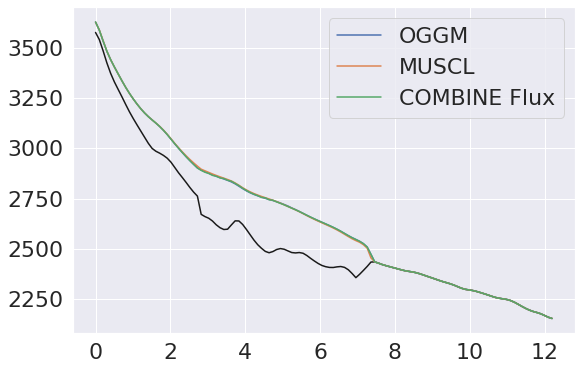

In [31]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, muscl_model.fls[-1].surface_h, label='MUSCL')
# plt.plot(distance_along_glacier, combine_diff_model.fls[-1].surface_h, label='COMBINE Diff')
plt.plot(distance_along_glacier, combine_flux_model.fls[-1].surface_h, label='COMBINE Flux')
plt.legend()

In [32]:
oggm_model.name = 'OGGM'
muscl_model.name = 'MUSCL'
#combine_diff_model.name = 'COMBINE Diff'
combine_flux_model.name = 'COMBINE Flux'
compare_vol([oggm_model, muscl_model, combine_flux_model])

                          OGGM          MUSCL   COMBINE Flux
           OGGM       0.00E+00       1.25E-05      -4.40E-07
          MUSCL      -1.25E-05       0.00E+00      -1.29E-05
   COMBINE Flux       4.40E-07       1.29E-05       0.00E+00


changing width

In [25]:
widths = fls[0].widths_m
# define a min width
widths = np.where(widths > 0, widths, 100)

oggm_fl = oggm_flowline(surface_h=surface_h, bed_h=bed_h,
                        widths=widths/map_dx, map_dx=map_dx)

combine_fl = combine_flowline(surface_h=surface_h, bed_h=bed_h,
                              widths=widths/map_dx, map_dx=map_dx, torch_type=torch.double)

ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)
#combine_diff_model = combine_DiffusiveFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
combine_flux_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)
#combine_flux_model_adapted = combine_FluxFlowlineModel_adapted(combine_fl, mb_model=mb_model, y0=0.)

years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      #'COMBINE Diff:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_diff_run, years), 
      #                                                   combine_diff_model.iterations) +
      'COMBINE Flux:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_flux_run, years), 
                                                         combine_flux_model.iterations))
      #'COMBINE Flux v2:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_flux_adapted_run, years), 
      #                                                   combine_flux_model_adapted.iterations))

OGGM: 0.50 s
COMBINE Flux:  1.88 s, Iterations: 4112



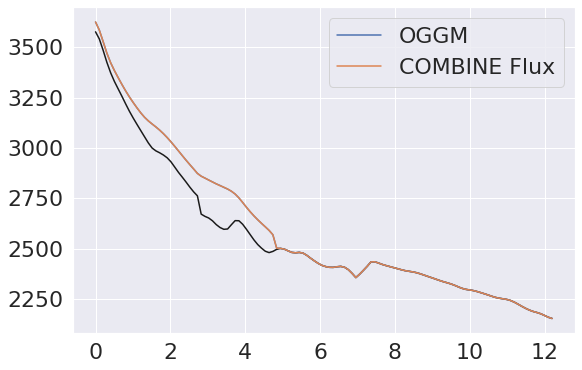

In [26]:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
# plt.plot(distance_along_glacier, combine_diff_model.fls[-1].surface_h, label='COMBINE Diff')
plt.plot(distance_along_glacier, combine_flux_model.fls[-1].surface_h, label='COMBINE Flux')
#plt.plot(distance_along_glacier, combine_flux_model_adapted.fls[-1].surface_h, label='COMBINE Flux v2')
plt.legend()

In [27]:
oggm_model.name = 'OGGM'
# combine_diff_model.name = 'COMBINE Diff'
combine_flux_model.name = 'COMBINE Flux'
#combine_flux_model_adapted.name = 'COMBINE Flux v2'
compare_vol([oggm_model, combine_flux_model])

                          OGGM   COMBINE Flux
           OGGM       0.00E+00       2.54E-06
   COMBINE Flux      -2.54E-06       0.00E+00


# First guess GlapTop

In [39]:
from combine.core.first_guess import first_guess_flowline

# get flowline with OGGM bed
gdir = gdirs[0]
fls = gdir.read_pickle('model_flowlines')
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3

# get ice flowline for GlapTop function
inv_fls = gdir.read_pickle('inversion_flowlines')
inv_fls_sfc = inv_fls[0].surface_h
inv_nx = inv_fls[0].nx
distance_along_inv_glacier = np.linspace(0, inv_nx, inv_nx) * dx * 1e-3

# calculate glacier bed
glaptop_bed = first_guess_flowline(inv_fls[0], inv_fls_sfc > 0, dx)

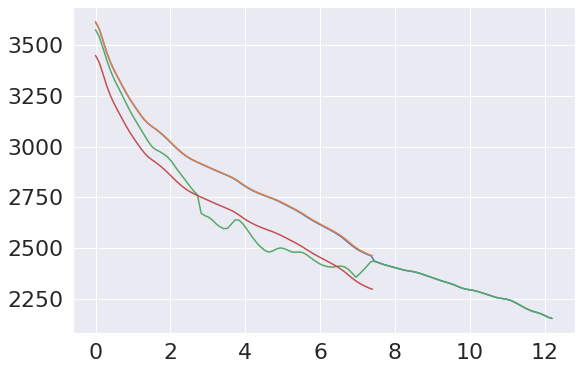

In [40]:
plt.plot(distance_along_glacier, fls[0].surface_h)
plt.plot(distance_along_inv_glacier, inv_fls_sfc)
plt.plot(distance_along_glacier, fls[0].surface_h - fls[0].thick)
plt.plot(distance_along_inv_glacier, glaptop_bed)

# Rectangular bed shape

## Hintereisferner bed with constant width

In [20]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test'
gdir = oggm.GlacierDirectory('RGI60-11.00897')
fls = gdir.read_pickle('model_flowlines')
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3
bed_h = fls[0].surface_h - fls[0].thick

surface_h = bed_h
widths = np.zeros(nx) + 1.

oggm_fl = oggm_flowline(surface_h=surface_h, bed_h=bed_h,
                             widths=widths/map_dx, map_dx=map_dx)

combine_fl = combine_flowline(surface_h=surface_h, bed_h=bed_h,
                                   widths=widths/map_dx, map_dx=map_dx, torch_type=torch.double)

ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [21]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 0.47 s
COMBINE:  1.88 s, Iterations: 4338



In [22]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00      -1.08E-19
        COMBINE       1.08E-19       0.00E+00


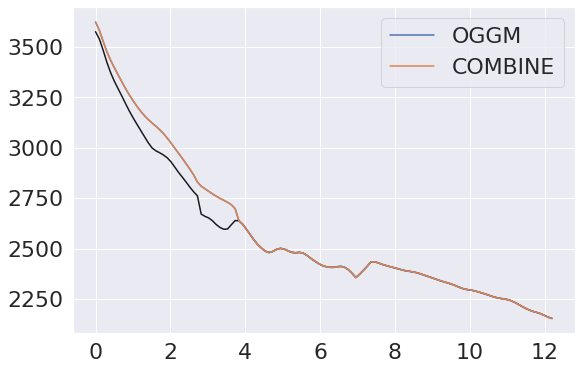

In [23]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()

# Parabolic bed shape

## linear bed

In [3]:
# number of steps from bottem to top of glacier
nx = 200

# model grid spacing in m
map_dx = 100

# distance along glacier (x-axis of glacier profil plot) in km
distance_along_glacier = np.linspace(0, nx, nx) * map_dx * 1e-3

# glacier top height
glacier_top_height = 4000

# glacier bottom height
glacier_bottom_height = 0

# define linear glacier bed with zero ice thickness
bed_h = np.linspace(glacier_top_height, 0, nx)
surface_h = bed_h

# define width, so glacier bed could be created when plot is created (after creation model is ready)
shape = np.zeros(nx) + 1.
widths = np.zeros(nx) + 4.

In [4]:
oggm_fl = oggm_para_flowline(surface_h=surface_h, bed_h=bed_h,
                             bed_shape=shape, map_dx=map_dx)

combine_fl = combine_para_flowline(surface_h=surface_h, bed_h=bed_h,
                                   bed_shape=shape, map_dx=map_dx, torch_type=torch.double)

In [5]:
ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

In [6]:
# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

In [7]:
def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [8]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 1.74 s
COMBINE:  6.35 s, Iterations: 12333



In [9]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00       1.21E-15
        COMBINE      -1.21E-15       0.00E+00


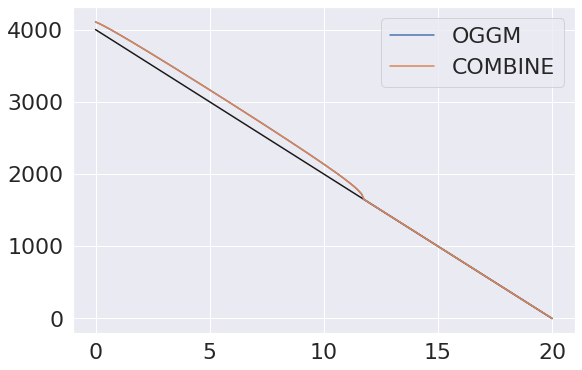

In [10]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()

## Hintereisferner bed with constant shape

In [36]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test'
gdir = oggm.GlacierDirectory('RGI60-11.00897')
fls = gdir.read_pickle('model_flowlines')
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3
bed_h = fls[0].surface_h - fls[0].thick

surface_h = bed_h
shape = np.zeros(nx) + 1.

oggm_fl = oggm_para_flowline(surface_h=surface_h, bed_h=bed_h,
                             bed_shape=shape, map_dx=map_dx)

combine_fl = combine_para_flowline(surface_h=surface_h, bed_h=bed_h,
                                   bed_shape=shape, map_dx=map_dx, torch_type=torch.double)

ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [37]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 0.61 s
COMBINE:  2.47 s, Iterations: 4943



In [38]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00       8.67E-19
        COMBINE      -8.67E-19       0.00E+00


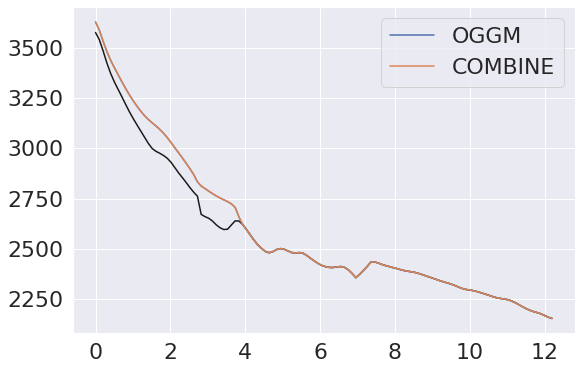

In [39]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()

## Hintereisferner with shanging shape factor

In [40]:
cfg.PATHS['working_dir'] = 'Hintereisferner_test'
gdir = oggm.GlacierDirectory('RGI60-11.00897')
fls = gdir.read_pickle('model_flowlines')
dx = fls[0].dx_meter
nx = fls[0].nx
distance_along_glacier = np.linspace(0, nx, nx) * dx * 1e-3
bed_h = fls[0].surface_h - fls[0].thick

surface_h = bed_h
shape = np.where(np.isnan(fls[0].bed_shape),
                 np.nanmin(fls[0].bed_shape),
                 fls[0].bed_shape)

oggm_fl = oggm_para_flowline(surface_h=surface_h, bed_h=bed_h,
                             bed_shape=shape, map_dx=map_dx)

combine_fl = combine_para_flowline(surface_h=surface_h, bed_h=bed_h,
                                   bed_shape=shape, map_dx=map_dx, torch_type=torch.double)

ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [41]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 0.59 s
COMBINE:  2.43 s, Iterations: 4784



In [42]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00       1.11E-16
        COMBINE      -1.11E-16       0.00E+00


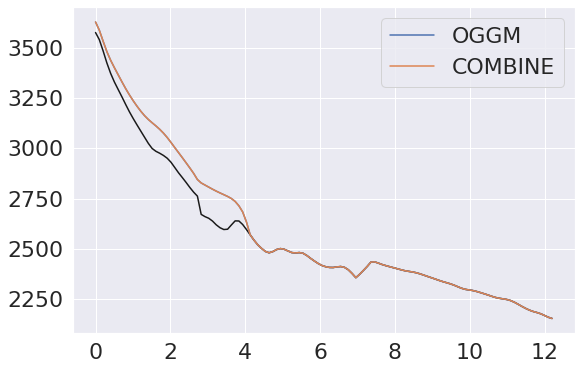

In [43]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()

# Trapezoidal bed shape

In [44]:
# number of steps from bottem to top of glacier
nx = 200

# model grid spacing in m
map_dx = 100

# distance along glacier (x-axis of glacier profil plot) in km
distance_along_glacier = np.linspace(0, nx, nx) * map_dx * 1e-3

# glacier top height
glacier_top_height = 4000

# glacier bottom height
glacier_bottom_height = 0

# define linear glacier bed with zero ice thickness
bed_h = np.linspace(glacier_top_height, 0, nx)
surface_h = bed_h

# define width, so glacier bed could be created when plot is created (after creation model is ready)
shape = np.zeros(nx) + 1.
widths = np.zeros(nx) + 4.

In [46]:
oggm_fl = oggm_trap_flowline(surface_h=surface_h, bed_h=bed_h,
                             lambdas=shape, widths=widths, map_dx=map_dx)

combine_fl = combine_trap_flowline(surface_h=surface_h, bed_h=bed_h,
                                   lambdas=shape, widths=widths, map_dx=map_dx, torch_type=torch.double)

In [47]:
ELA = 3000
mb_gradient = 4

mb_model = LinearMassBalance(ELA, grad=mb_gradient)

In [48]:
# initialize the actual model
oggm_model = oggm_FluxModel(oggm_fl, mb_model=mb_model, y0=0.)

combine_model = combine_FluxFlowlineModel(combine_fl, mb_model=mb_model, y0=0.)

In [49]:
def oggm_run(year):
    oggm_model.run_until(year)

def combine_run(year):
    combine_model.run_until(year)

In [50]:
years = 200

print('OGGM: {:.2f} s\n'.format(time_fct(oggm_run, years)) +
      'COMBINE:  {:.2f} s, Iterations: {:d}\n'.format(time_fct(combine_run, years), 
                                                      combine_model.iterations))

OGGM: 1.62 s
COMBINE:  5.62 s, Iterations: 10582



In [51]:
oggm_model.name = 'OGGM'
combine_model.name = 'COMBINE'
compare_vol([oggm_model, combine_model])

                          OGGM        COMBINE
           OGGM       0.00E+00       2.78E-15
        COMBINE      -2.78E-15       0.00E+00


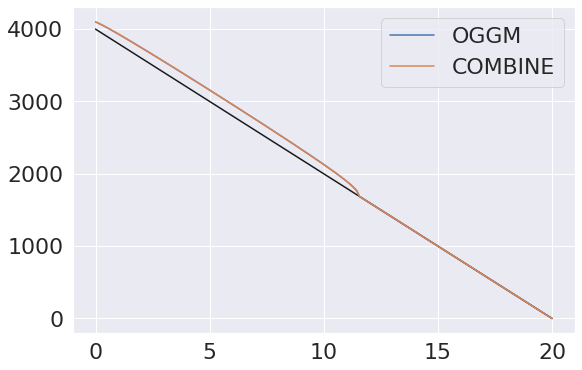

In [52]:
# Plot the final result:
plt.plot(distance_along_glacier, bed_h, 'k-')
plt.plot(distance_along_glacier, oggm_model.fls[-1].surface_h, label='OGGM')
plt.plot(distance_along_glacier, combine_model.fls[-1].surface_h, label='COMBINE')
plt.legend()